In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# ENSEMBLE models

* to reduce bias and variance
* using different models as building block of the final mode => weak learners
* different models can have low bias and high variance or vice versa
* combining several weak learners into one model with better performance
* choice of the weak learners should be coherent with aggregation method

### BAGGING
* less variance than it's component
* parallel learning
* averaging process

### BOOSTING
* less bias than it's components 
* sequential learning, base model depends on the previous one

### STACKING
* less bias than it's components
* parallel learning 
* combination of output of weak learners is input into the metamodel

#### Reasons for using ensemble models
* small dataset
* non-linear complicated data

### Error(x) = Bias^2 + Variance + irreducible Error 
![variance vs bias](https://miro.medium.com/max/700/1*kISLC1Udq0m6g5kwHhMuJg@2x.png)

##  STACKING

# https://www.sciencedirect.com/science/article/abs/pii/S0893608005800231

* base models
    * different types of models
    * again each of the model can have different strenghts on given dataset
* meta model
    * a single model is used to learn the best combination of the models

![stacking](https://mlfromscratch.com/content/images/2020/01/image-2.png)

* good generalization by meta model
* Stacked Generalization by David H. Wolpert (1992) paper shows that stacking deduces the bias which can be corrected by meta model

### architecture
* Level-0 Models - Base models
    * fits on the training data
* Level-1 Models - Meta model
    * learns the combination of the predictions of the base models
    
![stacking model](https://mlfromscratch.com/content/images/2020/01/model_stacking_new_diagram.png)    


### DATA

In [2]:
from sklearn import datasets
# https://en.wikipedia.org/wiki/Iris_flower_data_set

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

print(X.shape, y.shape)

(150, 2) (150,)


#### scikit-learn example

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [4]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

Accuracy: 0.922 (0.060) [KNN]
Accuracy: 0.918 (0.074) [Decision Tree]
Accuracy: 0.942 (0.064) [MLP]
Accuracy: 0.916 (0.064) [Naive Bayes]
Accuracy: 0.798 (0.080) [KRR]
Accuracy: 0.944 (0.049) [Stacking]


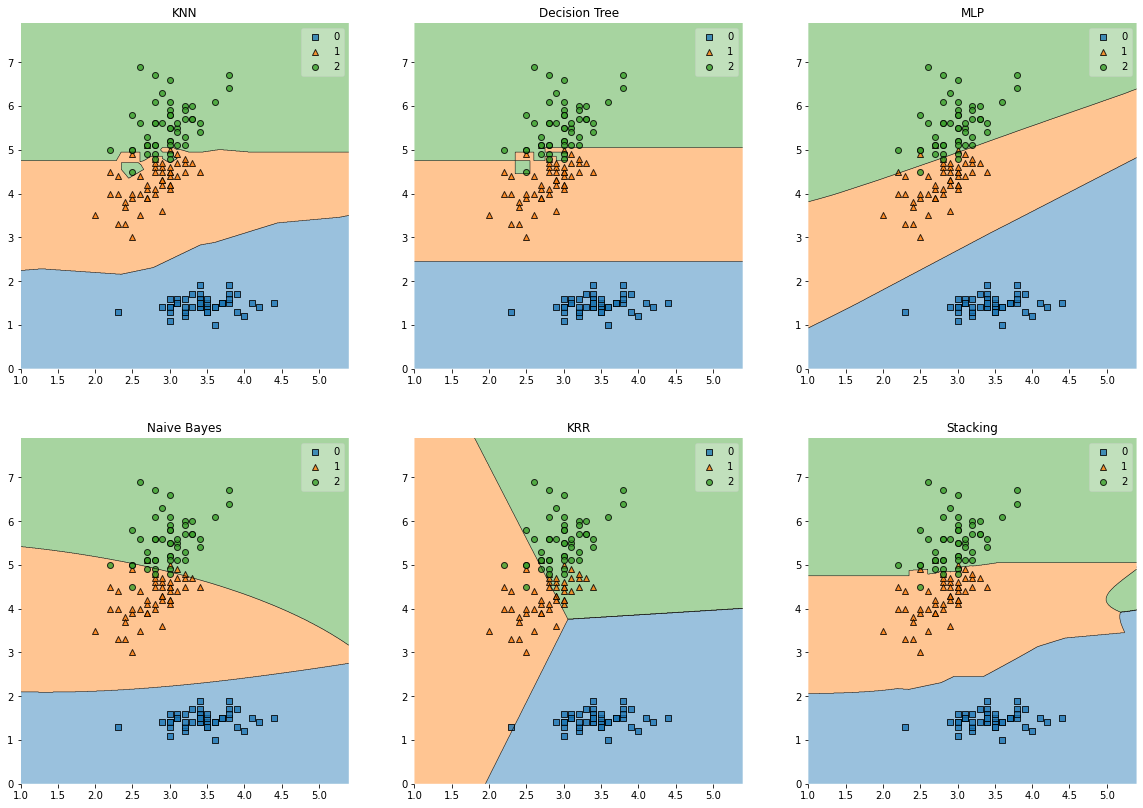

In [5]:
base1 = KNeighborsClassifier(n_neighbors=1)
base2 = DecisionTreeClassifier(random_state=1)
base3 = MLPClassifier(random_state=1, max_iter=1000)
base4 = GaussianNB()
base5 = RidgeClassifier()
estimators = [('knn', base1),
              ('dtc', base2),
              ('mlp', base3),
              ('nbc', base4),
              ('krr', base5)]

meta = LogisticRegression()
stacking = StackingClassifier(estimators=estimators, 
                              final_estimator=meta)

model_names = ['KNN', 'Decision Tree', 'MLP', 'Naive Bayes', 'KRR', 'Stacking']
clf_list = [base1, base2, base3, base4, base5, stacking]


fig, axs = plt.subplots(2, 3, figsize=(20,14))

# how to itertools:
# https://docs.python.org/3/library/itertools.html#itertools.product
# Cartesian product of input iterables (for nested loops)
grid = itertools.product([0,1,2],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, model_names, grid):
    scores = evaluate_model(clf, X, y)
    print("Accuracy: %.3f (%.3f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(axs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

,model,mean,std
4,KRR,0.797778,0.079784
3,Naive Bayes,0.915556,0.064253
1,Decision Tree,0.917778,0.074403
0,KNN,0.922222,0.059835
2,MLP,0.942222,0.063790
5,Stacking,0.944444,0.048939


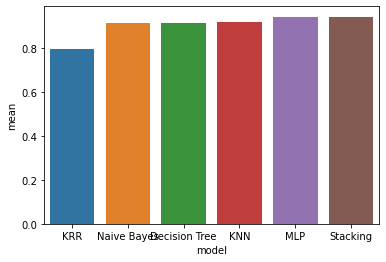

In [6]:
df_results = pd.DataFrame(zip(model_names, clf_cv_mean, clf_cv_std), columns=['model', 'mean', 'std']).sort_values(['mean'])

g = sns.barplot(x='model' ,y='mean', data=df_results)

df_results

Accuracy: 0.922 (0.060) [KNN]
Accuracy: 0.916 (0.064) [Naive Bayes]
Accuracy: 0.938 (0.062) [RFC]
Accuracy: 0.940 (0.053) [Stacking]


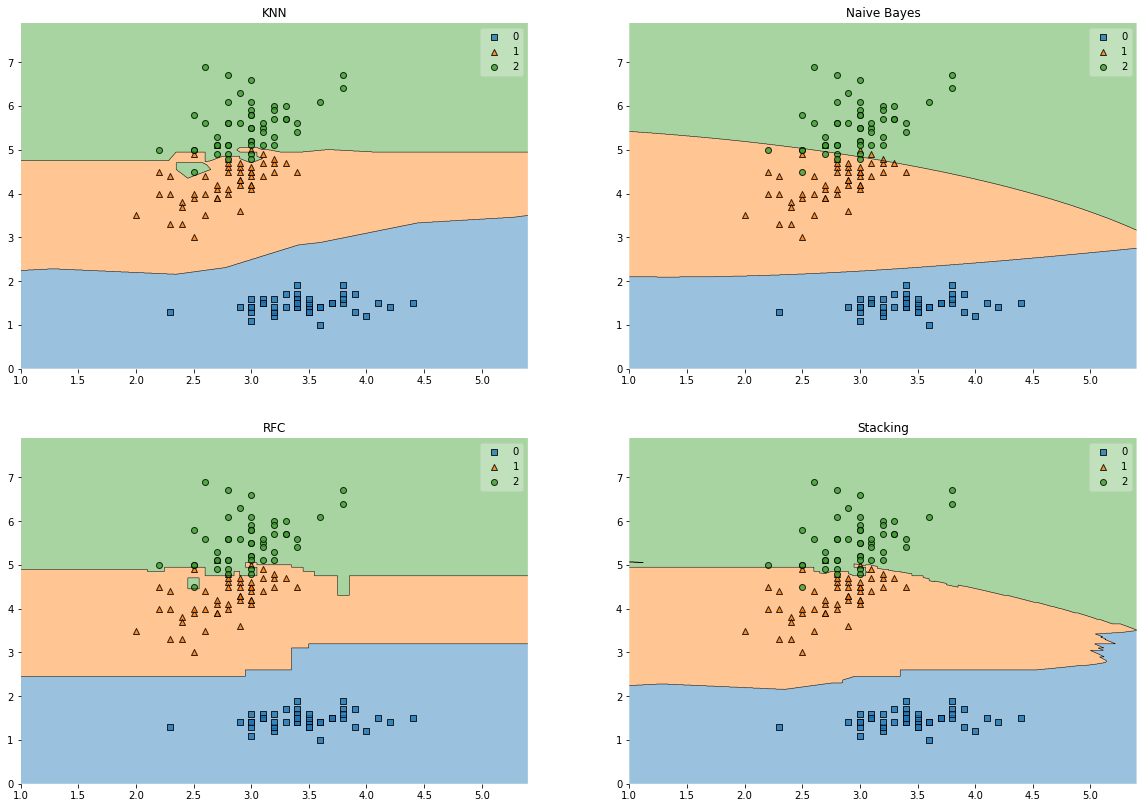

In [7]:
base1 = KNeighborsClassifier(n_neighbors=1)
base2 = GaussianNB()
base3 = RandomForestClassifier(random_state=1)
estimators = [('knn', base1),
              ('nbc', base2),
              ('rfc', base3)]

meta = LogisticRegression()
stacking = StackingClassifier(estimators=estimators, 
                              final_estimator=meta)

model_names = ['KNN', 'Naive Bayes', 'RFC', 'Stacking']
clf_list = [base1, base2, base3, stacking]
fig, axs = plt.subplots(2, 2, figsize=(20,14))
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, model_names, grid):
    scores = evaluate_model(clf, X, y)
    print("Accuracy: %.3f (%.3f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(axs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

C:\Users\kamcl\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\kamcl\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\kamcl\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


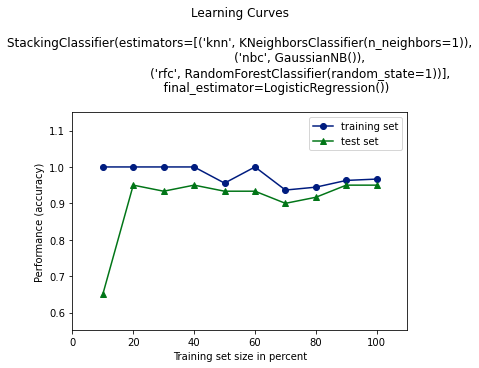

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
plt.figure()

plot_learning_curves(X_train, y_train, X_test, y_test, stacking, style='seaborn-dark-palette', scoring='accuracy')
plt.show()